# Correlation Power Analysis Project
<ul>
  <li>Author: Loh Zhi Heng (U2022581B), Liew Shaw Kee (U1922921D)</li>
  <li>Group: A124</li>
</ul>

In this project, the target system running a known algorithm AES-128 bit encryption. Where the algorithm takes in a 16-byte plaintext and 16-byte secret key in hexadecimal format, perform some computational rounds and outputs a 16-byte ciphertext.

While the target system performs the computational rounds, we're actively collecting side channel information in the form of power leakage. These sampled points are then used in the recovery of the secret key.

This form of attack is a <b>Passive Side Channel Attack (SCA)</b>. Why is it considered passive? It is considered passive as there are no changes in the parameters provided to the target system. The only thing that we're doing is collecting information leaked by the target system.

<b>Steps:</b>
<ol>
  <li>Set up the SCA board as per the laboratory slides</li>
  <li>Use the software provided on the school's computer to retrieve the power measurements, plaintext, and ciphertext</li>
  <li>Update the file location in this notebook</li>
  <li>Run this notebook in sequence</li>
</ol>

## What is correlation power analysis (CPA)?
Correlation power analysis is a form of side-channel attack. Where information leaked from a target system running a known algorithm is collected, and analysis is then performed on this data in an attempt to recover the key used.

## How does correlational power analysis (CPA) work?
CPA works by having some knowledge of the known algorithm running, in this case, the AES-128 algorithm. Where we know that in the SubBytes routine, we are able to make use of the output in an attempt to recover the key.

First, we would have to split the plaintext into byte level (2 hexadecimal characters).

Second, taking the each byte and XOR-ing it with the known possible key bytes [0x00 to 0xFF]. This will result in the leaky SBOX array which then we will use to calculate the Hamming Weight of.

Third, the hamming weight is used to calculate the number of bit '1' in the byte, this would then result in the power model matrix.

Last, the power model matrix will then be used together with the power measurements to calculate the correlation, for this project, we'll be using Pearson's Correlation. The highest correlation values found in each iteration will most likely result in the correct secret key byte.

In [ ]:
%pip install scipy matplotlib pandas numpy

In [2]:
from scipy import stats
import matplotlib.pyplot as plot
import pandas as pd
import numpy as np

In [2]:
# Modify this to point to the path where your power trace is saved
path_to_csv_trace = './waveform.csv'
num_of_hex_char_in_plaintext = 32
num_of_hex_in_byte = 2
key = 256
keys = np.arange(key)

## SBOX matrix used by the AES Engine
The SBOX matrix is used in the SubBytes step in the AES Engine.

SubBytes step takes an input from the AddBytes step and uses the SBOX matrix to map it to an intermediate output.

The intermediate output value from the SubBytes step is what we are using.

In [3]:
Sbox = (
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
)

## Function to calculate the Hamming Weight
Power consumption varies depending on the number of bits changed, hence it is possible to build a power model based on the hamming weights of the traces.

In [4]:
def hw(int_no):
    # Write Code to calculate the number of ones in a byte...
    c = 0
    while int_no > 0:
        c += (int_no & 1)
        int_no >>= 1
    return c

## Function to get the SBOX mapping
This creates the leaky SBOX array, function performs a XOR operation of the plaintext byte with the guessed key

In [5]:
def sboxMap(plaintext_byte, key_guess):
  return hw(Sbox[plaintext_byte ^ key_guess])

## Function that attempts to recover the key

It uses the Power Model Matrix created by using the intermediate value returned by the SubBytes function.

Performs the PearsonR operation to get the correlation of the Power Model Vector against the actual Power Trace.

The maximum value is then returned.

In [77]:
def findKey(traces, plaintext, show_graph = True, no_of_traces = 100):
    traces_transpose = np.asarray(traces[:no_of_traces]).transpose()
    actual_key = []
    actual_best_correlation_matrix = []
    for index in range(0, num_of_hex_char_in_plaintext, num_of_hex_in_byte):
        all_pt_all_keys_hamming_weight_matrix = [] # Power Model Matrix
        for pt in plaintext[:no_of_traces]:
            pt_byte = int(pt[index:index+num_of_hex_in_byte], 16)
            pt_all_keys = []
            for x in keys:
                intermediate_val = Sbox[pt_byte ^ x]
                hamming_weight = hw(intermediate_val)
                pt_all_keys.append(hamming_weight)
            all_pt_all_keys_hamming_weight_matrix.append(pt_all_keys) # Leaky SBOX Hamming Weights
        
        key_mat_correlation = []
        list_of_key_bytes_transpose = np.array(all_pt_all_keys_hamming_weight_matrix).transpose()
        for row in list_of_key_bytes_transpose:
            temp = []
            for col in traces_transpose:
                temp.append(abs(stats.pearsonr(row, col).correlation))
            key_mat_correlation.append(temp) # Correlation Matrix
        max_index = np.where(np.array(key_mat_correlation) == np.amax(np.array(key_mat_correlation)))
        k = hex(keys[max_index[0][0]])
        actual_key.append(k)

        best_correlation_val = []
        for i in keys:
            x = np.where(key_mat_correlation[i] == np.amax(key_mat_correlation[i]))
            best_correlation_val.append(key_mat_correlation[i][x[0][0]])
        
        order = np.argsort(best_correlation_val)
        order = order[::-1]
        actual_best_correlation_matrix.append(best_correlation_val)

        if show_graph :
            best = np.where(best_correlation_val == key_mat_correlation[max_index[0][0]][max_index[1][0]])
            plot.figure()
            plot.title(f"Correct Key Byte: {k}")
            plot.xlabel("Key Bytes")
            plot.ylabel("Correlation")
            plot.plot(keys, best_correlation_val)
            plot.plot(max_index[0][0], best_correlation_val[best[0][0]], 'r*')
            plot.show()

    return actual_key, actual_best_correlation_matrix

## Data Preparation
Read in the CSV and get the necessary parameters such as the number of traces and the number of runs

In [71]:
# Read the csv file into a dataframe
df = pd.read_csv(path_to_csv_trace, header=None)

# There's a Not A Number column of data, hence dropping it
df = df.drop(2502, axis=1)

# Removing plaintext column from the dataframe
less_pt_df = df.drop(0, axis=1)

# Removing ciphertext column from the dataframe
traces_df = less_pt_df.drop(1, axis=1)

num_of_traces, num_of_measurements = df.shape
# No. of traces less the plaintext and ciphertext
num_of_measurements -= 2
print(f"No. of rows: {num_of_traces}, No. of traces: {num_of_measurements}")

# Arrays that we'll be working with
plaintext = df[0].values
traces = traces_df.values
traces_transpose = np.array(traces).transpose()

all_key_bytes_correlation_matrix = []

No. of rows: 100, No. of traces: 2500


## Plot 1
This will retrieve the secret key used in the AES-128 encryption.

This will also plot the correlation matrix of each key byte found.

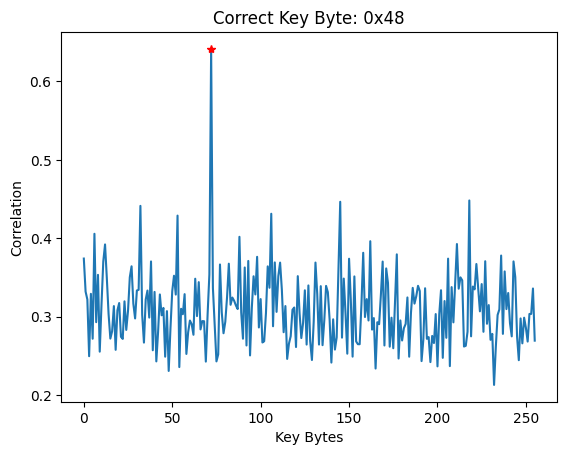

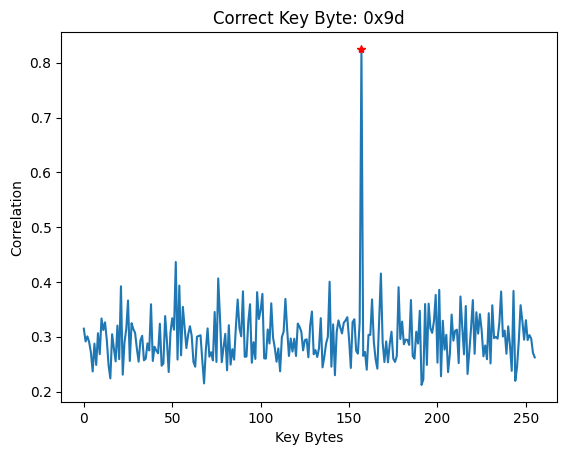

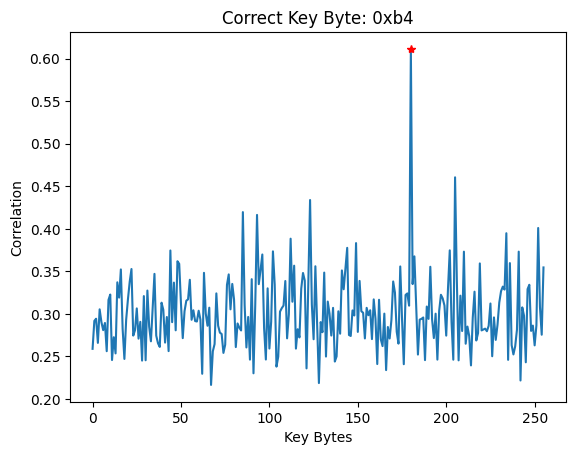

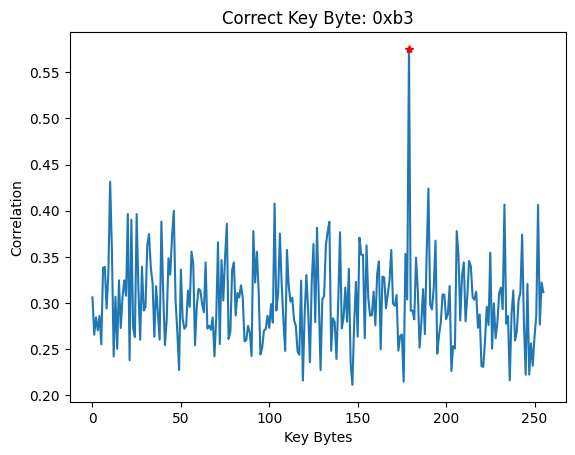

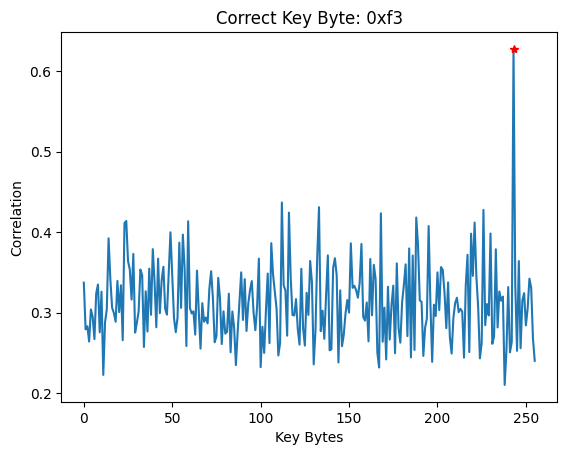

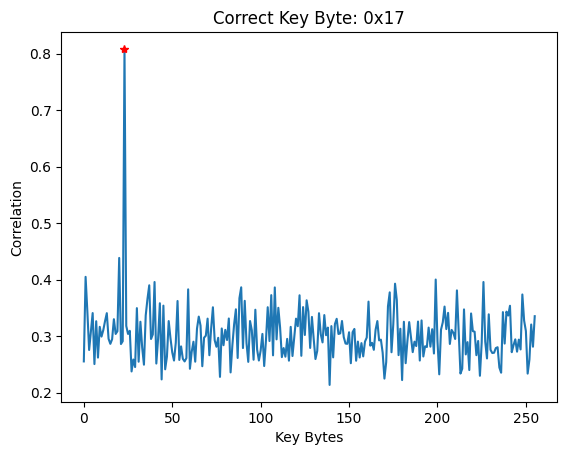

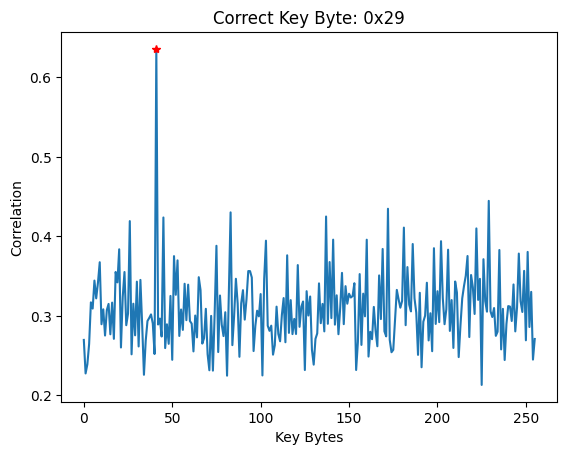

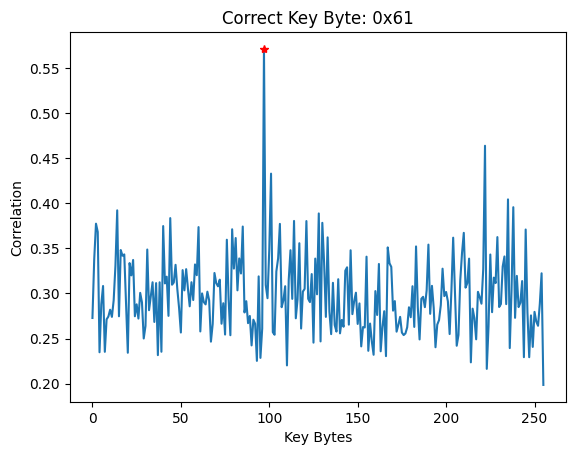

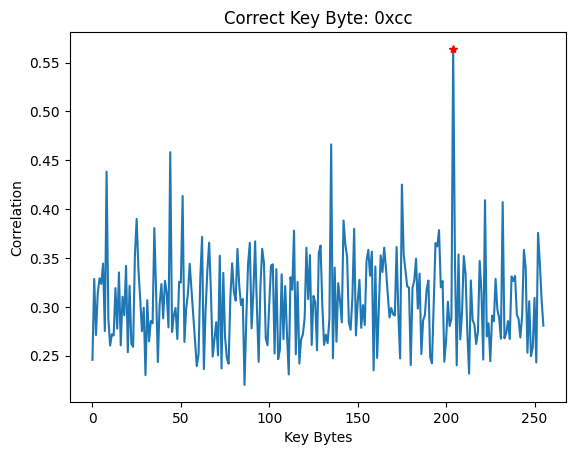

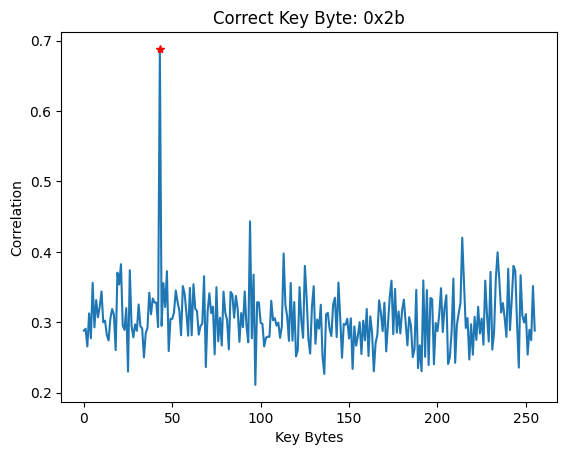

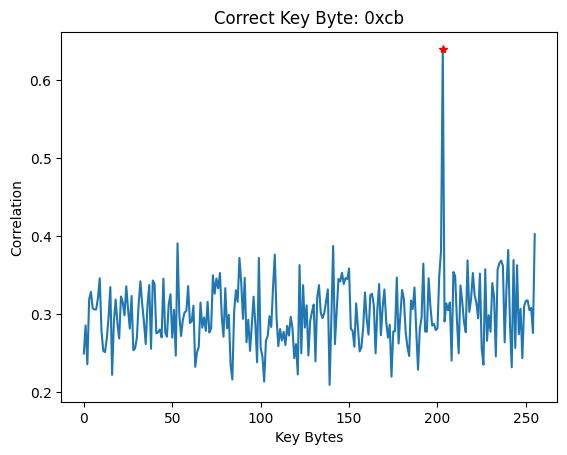

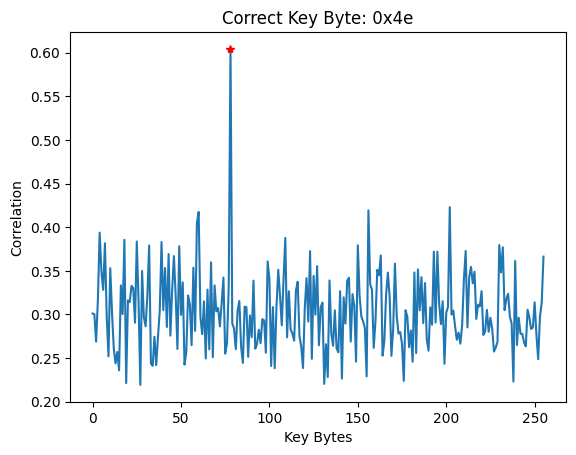

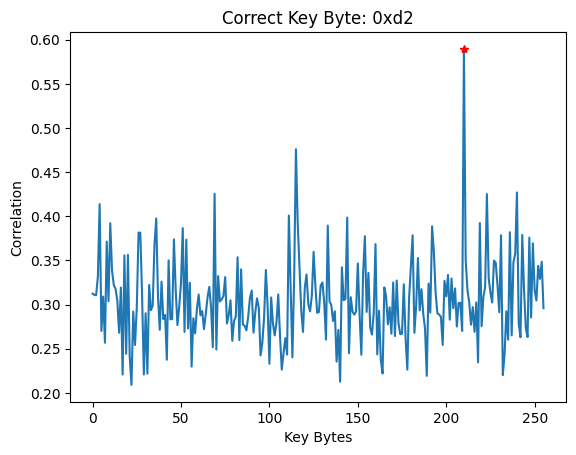

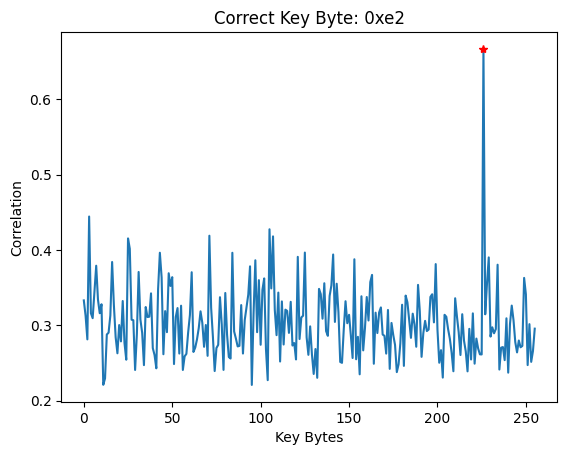

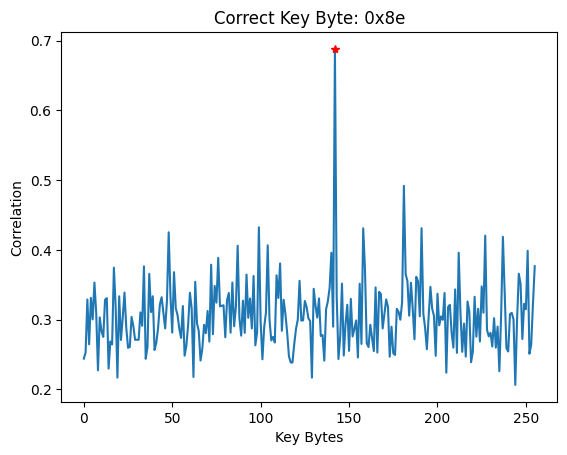

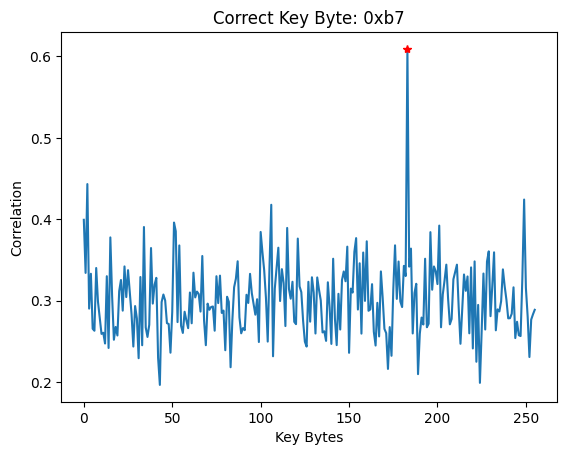

['0x48', '0x9d', '0xb4', '0xb3', '0xf3', '0x17', '0x29', '0x61', '0xcc', '0x2b', '0xcb', '0x4e', '0xd2', '0xe2', '0x8e', '0xb7']


In [75]:
key100, correlation100 = findKey(traces, plaintext, True, num_of_traces)
print(key100)

## Plot 2

This section will retrieve the key using 90 down to 10 traces at 10 trace intervals.

This will not plot the correlation as show in plot 1 yet.

In [78]:
key90, correlation90 = findKey(traces, plaintext, False, 90)
print(key90)

['0x48', '0x9d', '0xb4', '0xb3', '0xf3', '0x17', '0x29', '0x61', '0xcc', '0x2b', '0xcb', '0x4e', '0xd2', '0xe2', '0x8e', '0xb7']


In [79]:
key80, correlation80 = findKey(traces, plaintext, False, 80)
print(key80)

['0x48', '0x9d', '0xb4', '0xb3', '0xf3', '0x17', '0x29', '0xde', '0xcc', '0x2b', '0xcb', '0x4e', '0xd2', '0xe2', '0x8e', '0xb7']


In [80]:
key70, correlation70 = findKey(traces, plaintext, False, 70)
print(key70)

['0x48', '0x9d', '0xcd', '0xb3', '0xf3', '0x17', '0x29', '0x92', '0xcc', '0x2b', '0xcb', '0x4e', '0xd2', '0xe2', '0x8e', '0xb7']


In [81]:
key60, correlation60 = findKey(traces, plaintext, False, 60)
print(key60)

['0x48', '0x9d', '0xcd', '0x95', '0xf3', '0x17', '0x29', '0x9e', '0xc4', '0x2b', '0xcb', '0x4e', '0xd2', '0xe2', '0x8e', '0xb7']


In [82]:
key50, correlation50 = findKey(traces, plaintext, False, 50)
print(key50)

['0x48', '0x9d', '0xcd', '0x95', '0xf3', '0x17', '0x29', '0xe9', '0xcc', '0x2b', '0xcb', '0x6d', '0x3b', '0xe2', '0x8e', '0x69']


In [83]:
key40, correlation40 = findKey(traces, plaintext, False, 40)
print(key40)

['0x6e', '0x9d', '0x19', '0x2b', '0xf3', '0x17', '0x14', '0xeb', '0xaa', '0x34', '0xcb', '0x4e', '0x3c', '0xe2', '0x8e', '0xb7']


In [84]:
key30, correlation30 = findKey(traces, plaintext, False, 30)
print(key30)

['0xda', '0x9d', '0x28', '0x95', '0xf3', '0x17', '0xb0', '0xeb', '0x74', '0x34', '0xb1', '0xab', '0x3c', '0xc7', '0x8e', '0x2a']


In [85]:
key20, correlation20 = findKey(traces, plaintext, False, 20)
print(key20)

['0x50', '0xcd', '0x1f', '0xbe', '0xb2', '0xf5', '0x4', '0x85', '0x80', '0x9e', '0x46', '0x29', '0xbb', '0x5d', '0x20', '0xf3']


In [86]:
key10, correlation10 = findKey(traces, plaintext, False, 10)
print(key10)

['0x92', '0x45', '0x98', '0xdc', '0x63', '0x0', '0x2d', '0xe3', '0x39', '0xeb', '0xa6', '0x88', '0xcb', '0x63', '0x79', '0x67']


### Saving of correlation matrices
Saving the correlation for each interval of traces.

Doing so because it takes a really long time to recover the key and calculate the correlation.

In [ ]:
np.savetxt('correlation100.csv', correlation100, delimiter=",")
np.savetxt('correlation90.csv', correlation90, delimiter=",")
np.savetxt('correlation80.csv', correlation80, delimiter=",")
np.savetxt('correlation70.csv', correlation70, delimiter=",")
np.savetxt('correlation60.csv', correlation60, delimiter=",")
np.savetxt('correlation50.csv', correlation50, delimiter=",")
np.savetxt('correlation40.csv', correlation40, delimiter=",")
np.savetxt('correlation30.csv', correlation30, delimiter=",")
np.savetxt('correlation20.csv', correlation20, delimiter=",")
np.savetxt('correlation10.csv', correlation10, delimiter=",")

### Saving the recovered key
The recovered key is then saved as a csv file for comparison.

In [94]:
key_df_100_to_10 = pd.DataFrame([key100, key90, key80, key70, key60, key50, key40, key30, key20, key10])
key_df_100_to_10.to_csv('key_df_100_to_10.csv', header=None, index=None)

### Loading the correlation csv file
Loads the saved correlation matrices for each trace interval.

In [5]:
correlation10 = pd.read_csv('./correlation10.csv', header=None).to_numpy()
correlation20 = pd.read_csv('./correlation20.csv', header=None).to_numpy()
correlation30 = pd.read_csv('./correlation30.csv', header=None).to_numpy()
correlation40 = pd.read_csv('./correlation40.csv', header=None).to_numpy()
correlation50 = pd.read_csv('./correlation50.csv', header=None).to_numpy()
correlation60 = pd.read_csv('./correlation60.csv', header=None).to_numpy()
correlation70 = pd.read_csv('./correlation70.csv', header=None).to_numpy()
correlation80 = pd.read_csv('./correlation80.csv', header=None).to_numpy()
correlation90 = pd.read_csv('./correlation90.csv', header=None).to_numpy()
correlation100 = pd.read_csv('./correlation100.csv', header=None).to_numpy()

### Plots the correlation of correct key byte vs number of traces graph
Actual plot 2!

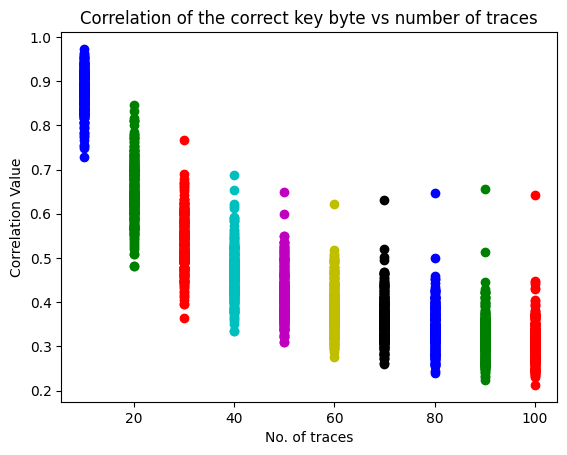

In [6]:
plot.figure()
plot.title("Correlation of the correct key byte vs number of traces")
plot.xlabel('No. of traces')
plot.ylabel('Correlation Value')
for i in correlation10[0]:
    plot.plot(10, i, 'ob')
for i in correlation20[0]:
    plot.plot(20, i, 'og')
for i in correlation30[0]:
    plot.plot(30, i, 'or')
for i in correlation40[0]:
    plot.plot(40, i, 'oc')
for i in correlation50[0]:
    plot.plot(50, i, 'om')
for i in correlation60[0]:
    plot.plot(60, i, 'oy')
for i in correlation70[0]:
    plot.plot(70, i, 'ok')
for i in correlation80[0]:
    plot.plot(80, i, 'ob')
for i in correlation90[0]:
    plot.plot(90, i, 'og')
for i in correlation100[0]:
    plot.plot(100, i, 'or')
plot.show()